# GROUP 7 DSFT09 HYBRID PHASE 4
1.Mirriam Mumbua<br>
2.Martin Kandie<br>
3.Gilead Gad <br>
4.Roobinson Karasha<br>
5.Graffin Kiprotich<br>

 # Multi-Label Emotion Classification Using NLP: Analyzing Emotional Tone in Social Media and Text Data

![Local Image](./emotionimage.png)

## Project overview
### Problem Statement
##### This project aims to build an emotion classifier using the GoEmotions dataset, which includes human-labeled Reddit comments annotated for 27 emotion categories. The goal is to develop a model that can accurately classify text into one of these emotions, which can be applied to analyzing social media comments, reviews, or even customer feedback to detect emotional tone.

### Dataset
##### The GoEmotions dataset was sourced from Reddit, a popular social media platform where users post comments on various topics. Specifically, the dataset consists of over 58,000 Reddit comments that were manually annotated by human labelers into 27 distinct emotion categories (such as joy, anger, sadness, curiosity, and more).The dataset was created by Google Research as part of their efforts to advance Natural Language Processing (NLP) research. The comments were collected from publicly available Reddit posts, ensuring a wide variety of topics and emotional expressions. The comments were then labeled with one or more emotions, making it a multi-label classification problem.

## Objective
### Develop a machine learning model capable of:
* ##### Multi-label emotion detection: Predicting one or more emotion categories for each Reddit comment from the 27 possible emotion classes.
* ##### Handling noisy and real-world text: Effectively preprocessing the text (e.g., dealing with slang, abbreviations, and varied sentence structures in Reddit comments) to ensure accurate predictions.
* #####  Accurate classification: Maximizing the model's performance on key metrics for multi-label classification (such as F1-score, precision, and recall) across all 27 emotion categories.

## Expected Outcome
### The final model will:

##### Take a Reddit comment as input.
##### Output one or more emotion labels (from the 27 possible emotions) that best represent the emotional tone of the comment.

## Applications
### This emotion detection model could be applied to:

* ##### Social media monitoring: To understand public sentiment on platforms like Reddit, Twitter, and Facebook.
* #####  Customer feedback analysis: For detecting emotional tone in product reviews or customer support conversations.
* ##### Mental health monitoring: To detect signs of distress or mental health issues in text-based communications on forums or in private messages.



Business Understanding

Data Understanding 

## Importing Necessary Libraries

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import json
from wordcloud import WordCloud
import emoji
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

## Loading the Data and Pre_processing

In [69]:
# Load the training data
train_data = pd.read_csv('full_dataset/train.tsv', sep='\t', header=None ,names=['text', 'label', 'id'])

# Load the validation data
dev_data = pd.read_csv('full_dataset/dev.tsv', sep='\t', header=None,names=['text', 'label', 'id'])
# test data 
test_data = pd.read_csv('full_dataset/test.tsv', sep='\t', header=None,names=['text', 'label', 'id'])

#Initial Data inspection
train_data.head()
dev_data.head()
test_data.head()


,text,label,id
0,I’m really sorry about your situation :( Altho...,25,eecwqtt
1,It's wonderful because it's awful. At not with.,0,ed5f85d
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1
4,They got bored from haunting earth for thousan...,27,eem5uti


In [70]:
#splitting labels and counting class Lengths
train_data['List of classes'] = train_data['label'].apply(lambda x: x.split(','))
train_data['Len of classes'] = train_data['List of classes'].apply(lambda x: len(x))

test_data['List of classes'] = test_data['label'].apply(lambda x: x.split(','))
test_data['Len of classes'] = test_data['List of classes'].apply(lambda x: len(x))

dev_data['List of classes'] = dev_data['label'].apply(lambda x: x.split(','))
dev_data['Len of classes'] = dev_data['List of classes'].apply(lambda x: len(x))

This block reads a JSON file (ekman_mapping.json) that contains mappings from finer-grained emotion labels to broader emotion categories (such as "anger", "joy", etc.).

In [71]:
with open('full_dataset/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

The JSON file is loaded into the variable ekman_mapping, which can then be used to map specific emotions to broader emotion categories later on.

The Next line of code opens a text file (emotions.txt) that contains a list of emotions (one emotion per line).
The file is read into a string, which is then split into a list of emotions using split("\n"), where each emotion is stored on a new line.

### Data Pre_processing

In [72]:
emotion_file = open("full_dataset/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [73]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

Using the emotion_list (which was previously loaded), this function (idx2class) takes a list of emotion label indices (idx_list) and converts them to their corresponding emotion names.
After being translated to integers, the emotion label indices are mapped to the corresponding emotion class names.

In [74]:
#Applying Emotion Mapping to DataFrames.
train_data['Emotions'] = train_data['List of classes'].apply(idx2class)
test_data['Emotions'] = test_data['List of classes'].apply(idx2class)
dev_data['Emotions'] = dev_data['List of classes'].apply(idx2class)

The result is a new column (Emotions) that contains the emotion names (e.g., "joy", "anger") instead of the raw label indices.

In [75]:
#Function for Mapping Emotions to Broader Categories
def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')
            
    return map_list

In [76]:
#convert the classes based on ekman taxonomy
train_data['Mapped Emotions'] = train_data['Emotions'].apply(EmotionMapping)
test_data['Mapped Emotions'] = test_data['Emotions'].apply(EmotionMapping)
dev_data['Mapped Emotions'] = dev_data['Emotions'].apply(EmotionMapping)

In [81]:
train_data["Mapped Emotions"] = train_data["Mapped Emotions"].apply(lambda x: ','.join(x))
test_data["Mapped Emotions"] = test_data["Mapped Emotions"].apply(lambda x: ','.join(x))
dev_data["Mapped Emotions"] = dev_data["Mapped Emotions"].apply(lambda x: ','.join(x))

In [82]:
train_data.head()

,text,label,id,List of classes,Len of classes,Emotions,Mapped Emotions
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],neutral
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],neutral
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],anger
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],fear
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],anger


In [83]:
train_data = train_data.drop(["label", "List of classes", "Len of classes", "Emotions"], axis=1)
test_data = test_data.drop(["label", "List of classes", "Len of classes", "Emotions"], axis=1)
dev_data = dev_data.drop(["label", "List of classes", "Len of classes", "Emotions"], axis=1)

In [87]:
train_data_1= train_data["Mapped Emotions"].str.split(",", expand=True)
test_data_1= test_data["Mapped Emotions"].str.split(",", expand=True)
dev_data_1= dev_data["Mapped Emotions"].str.split(",", expand=True)

In [89]:
train_data_1.drop(train_data_1.columns[1:5], axis=1, inplace=True)
test_data_1.drop(test_data_1.columns[1:5], axis=1, inplace=True)
dev_data_1.drop(dev_data_1.columns[1:5], axis=1, inplace=True)

In [91]:
train_data = pd.concat([train_data, train_data_1], axis=1)
test_data = pd.concat([test_data, test_data_1], axis=1)
dev_data = pd.concat([dev_data, dev_data_1], axis=1)

In [92]:
train_data.rename(columns={0: "Emotion"}, inplace=True)
test_data.rename(columns={0: "Emotion"}, inplace=True)
dev_data.rename(columns={0: "Emotion"}, inplace=True)

In [95]:
train_data.head()
test_data.head()
dev_data.head()

,text,id,Mapped Emotions,Emotion
0,Is this in New Orleans?? I really feel like th...,edgurhb,neutral,neutral
1,"You know the answer man, you are programmed to...",ee84bjg,"joy,neutral",joy
2,I've never been this sad in my life!,edcu99z,sadness,sadness
3,The economy is heavily controlled and subsidiz...,edc32e2,"joy,neutral",joy
4,He could have easily taken a real camera from ...,eepig6r,joy,joy


In [98]:
train_data = train_data.drop(["Mapped Emotions"], axis=1)
test_data = test_data.drop(["Mapped Emotions"], axis=1)
dev_data = dev_data.drop(["Mapped Emotions"], axis=1)

In [109]:
#dropping Duplicated columns.
train_data = train_data.loc[:, ~train_data.columns.duplicated()]
test_data = test_data.loc[:, ~test_data.columns.duplicated()]


#train_data.head()
#test_data.head()

In [108]:
#Checking if the data is balanced or not
train_data.Emotion.value_counts()

Emotion
joy         16948
neutral     12823
anger        5336
surprise     4489
sadness      2619
fear          615
disgust       580
Name: count, dtype: int64

There is a large disparity between the most frequent emotion (joy with 16,948 samples) and the least frequent (disgust with 580 samples).
The minority classes (fear, disgust, sadness, etc.) have significantly fewer samples compared to the majority classes (joy and neutral).Hence the Data is Imbalanced

### Word Cloud

Let us perform som mild Data Aalysis by generating word clouds for each Emotion present in our Dataset

Word clouds enable viewers to quickly understand important themes and subjects by offering a visual representation of the most frequently occurring words or phrases in a dataset.
They facilitate the discovery of patterns and trends in text data, which facilitates the comprehension of the underlying messages.
Comparing Datasets: By building word clouds from multiple datasets (e.g., customer feedback vs. competitor analysis), you can graphically compare and contrast themes and keywords.

In [110]:
emotion_list = train_data["Emotion"].unique()
emotion_list

array(['neutral', 'anger', 'fear', 'surprise', 'joy', 'sadness',
       'disgust'], dtype=object)

In [111]:
def word_cloud(wordcloud, df):
    
    plt.figure(figsize=(10, 10))
    plt.suptitle(df + " Word Cloud", size=15)
    plt.imshow(wordcloud)
    plt.axis("off")

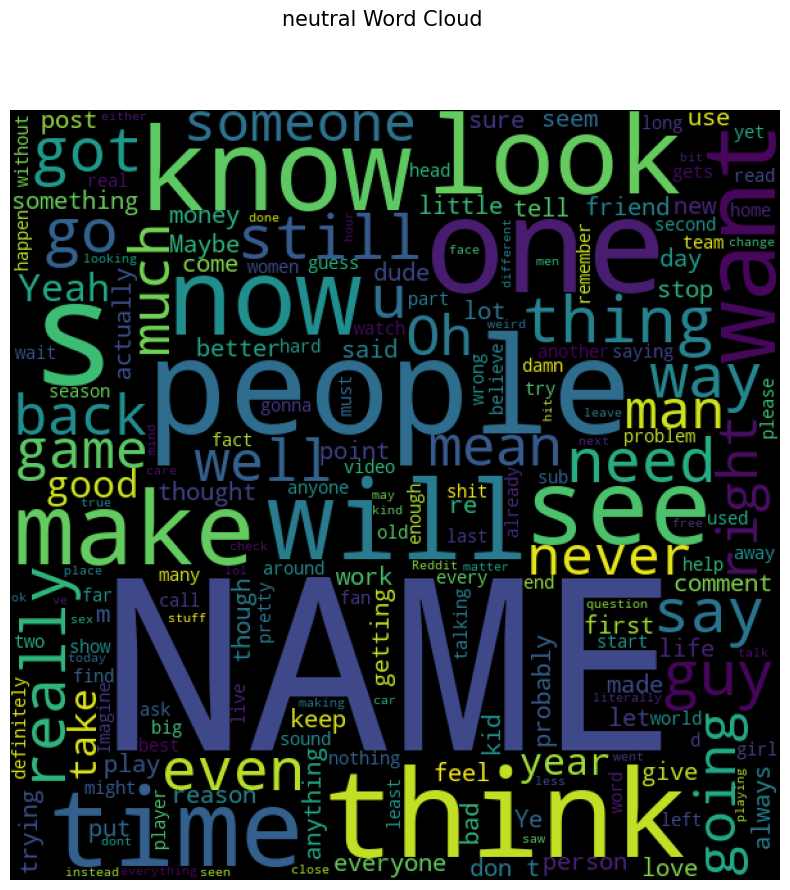

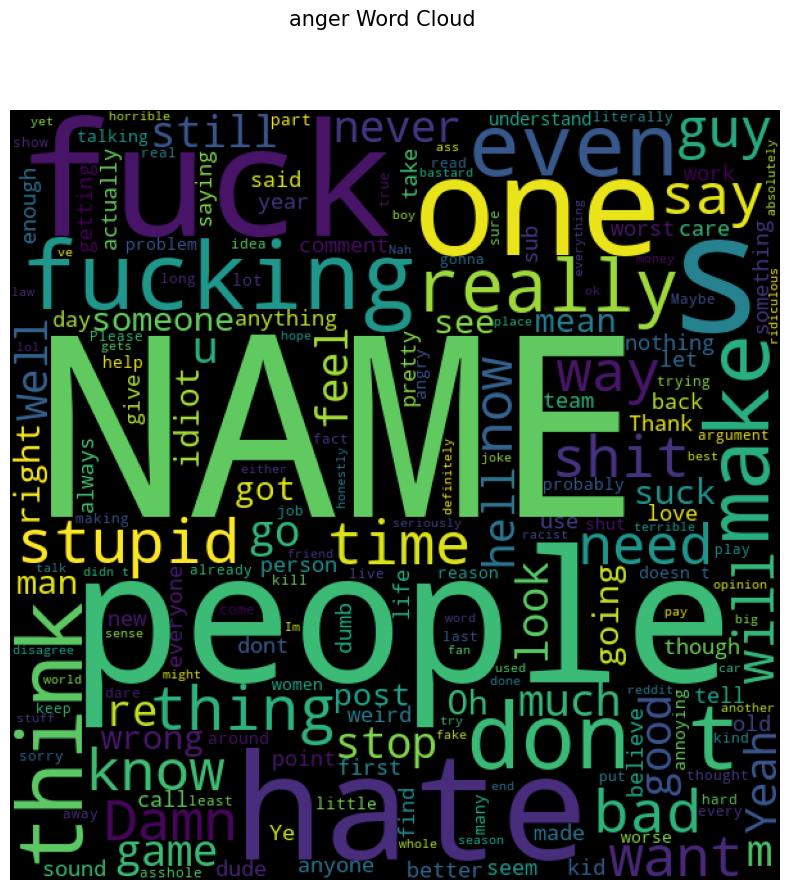

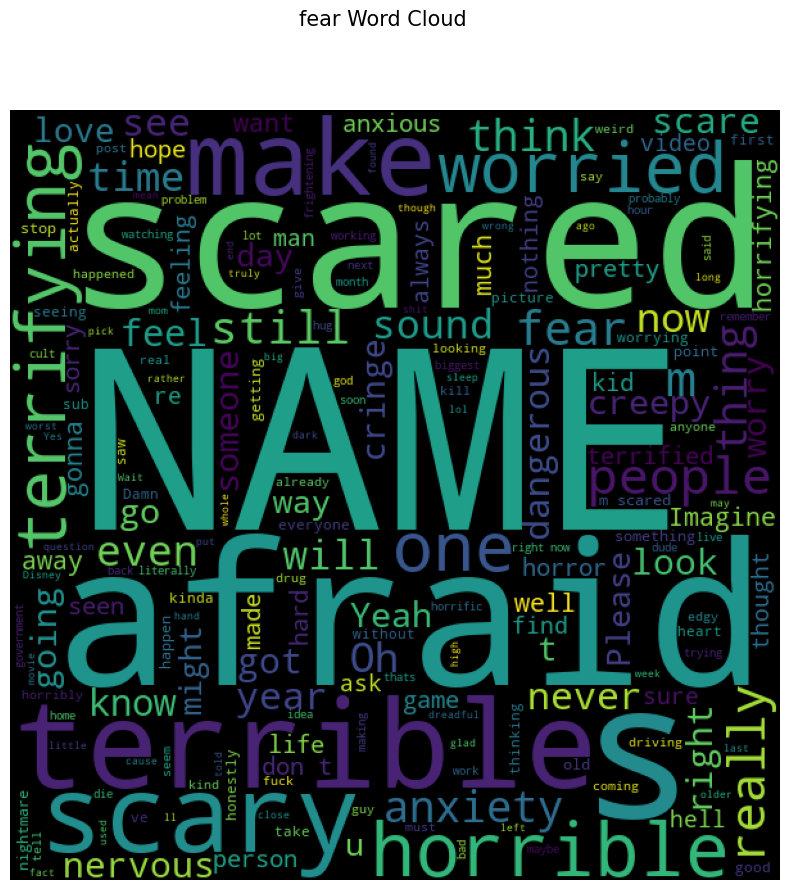

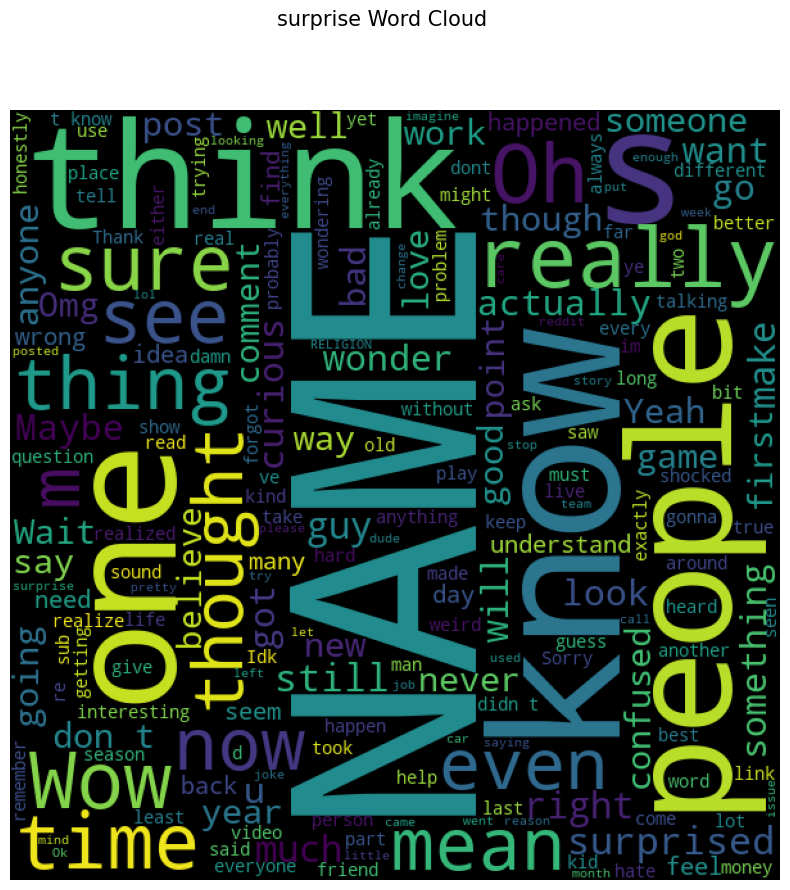

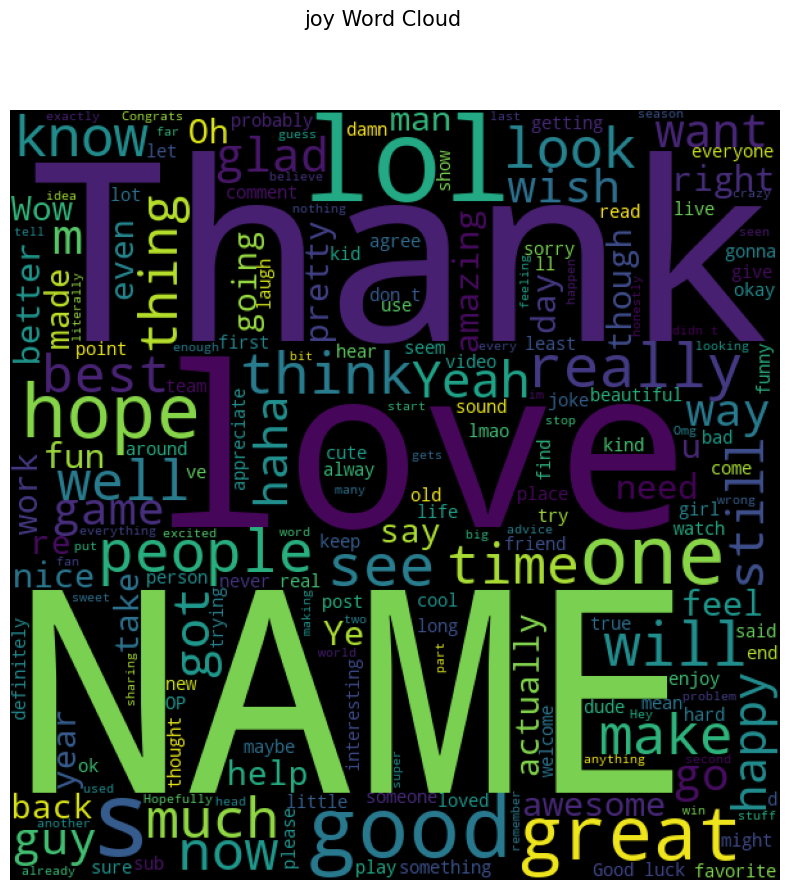

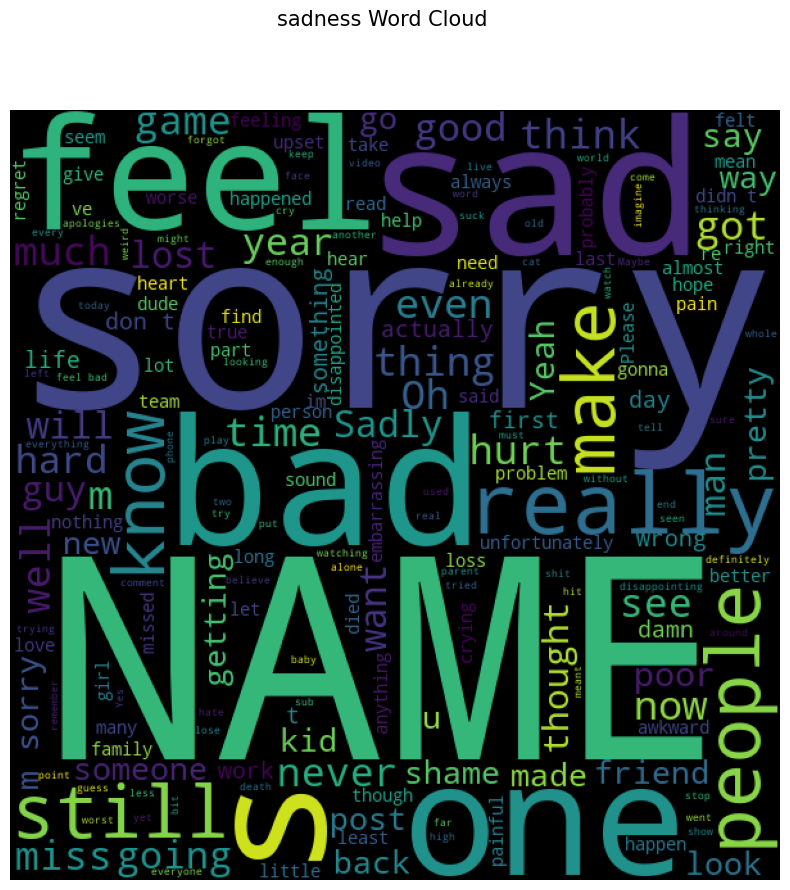

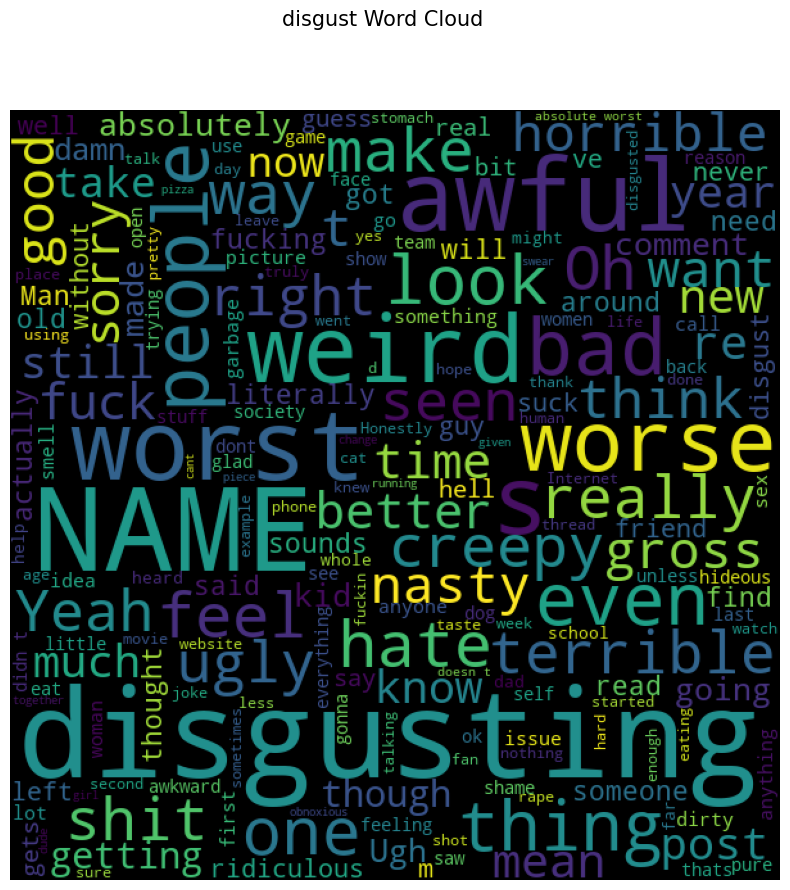

In [115]:
for emotion in emotion_list:
    text = " ".join([sentence for sentence in train_data.loc[train_data["Emotion"] == emotion, "text"]])
    wordcloud = WordCloud(width=600, height=600).generate(text)
    word_cloud(wordcloud, emotion)

In [116]:
train_data["Emotion"] = train_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
test_data["Emotion"] = test_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
dev_data["Emotion"] = dev_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})

### Data cleaning

In [123]:
class DataInfo:
    
    def __init__(self, df):
        # Initialize with a DataFrame
        self.df = df
        
    def get_shape(self):
        # Return the shape of the DataFrame
        shape = self.df.shape
        print(f"Shape of the DataFrame: {shape}")
        return shape
    
    def get_dtypes(self):
        # Return the data types of each column
        dtypes = self.df.dtypes
        print("Data types of each column:")
        print(dtypes)
        return dtypes
    
    def get_missing_values(self):
        # Return the number of missing values per column
        missing_values = self.df.isnull().sum()
        print("Missing values per feature:")
        print(missing_values)
        return missing_values
    
    def get_basic_info(self):
        # Print basic info including shape, data types, and missing values
        print("Basic Information:")
        self.get_shape()
        self.get_dtypes()
        self.get_missing_values()
        
    def remove_duplicates(self):
        # Remove duplicate entries based on the 'post' column
        initial_shape = self.df.shape
        self.df.drop_duplicates(subset='text', inplace=True)
        final_shape = self.df.shape
        print(f"Removed {initial_shape[0] - final_shape[0]} duplicate rows.")
        print(f"New shape of the DataFrame: {final_shape}")
        return self.df

In [124]:
# Instantiating our class
train_info = DataInfo(train_data)
test_info = DataInfo(test_data)
dev_info = DataInfo(dev_data)

# Get missing values for each DataFrame
train_info.get_missing_values()
test_info.get_missing_values()
dev_info.get_missing_values()

Missing values per feature:
text       0
id         0
Emotion    0
dtype: int64
Missing values per feature:
text       0
id         0
Emotion    0
dtype: int64
Missing values per feature:
text       0
id         0
Emotion    0
dtype: int64


text       0
id         0
Emotion    0
dtype: int64

It looks like there are no Missing values in our Dataset

In [125]:
# Get Duplicates values for each DataFrame
train_info.remove_duplicates()
test_info.remove_duplicates()
dev_info.remove_duplicates()

Removed 183 duplicate rows.
New shape of the DataFrame: (43227, 3)
Removed 6 duplicate rows.
New shape of the DataFrame: (5421, 3)
Removed 3 duplicate rows.
New shape of the DataFrame: (5423, 3)


,text,id,Emotion
0,Is this in New Orleans?? I really feel like th...,edgurhb,6
1,"You know the answer man, you are programmed to...",ee84bjg,3
2,I've never been this sad in my life!,edcu99z,4
3,The economy is heavily controlled and subsidiz...,edc32e2,3
4,He could have easily taken a real camera from ...,eepig6r,3
...,...,...,...
5421,It's pretty dangerous when the state decides w...,edyrazk,2
5422,I filed for divorce this morning. Hoping he mo...,edi2z3y,3
5423,"The last time it happened I just said, ""No"" an...",eewbqtx,0
5424,I can’t stand this arrogant prick he’s no bett...,eefx57m,0


We can now proceed to the next stage where we are going to remove any emojis present in our dataset, remove punctuation, lowercase all the posts, remove any noise such as mentions and hashtags, filter-out non-english words, lemmitize and then tokenize our data

In [131]:
def remove_pattern(text, pattern_regex):
    """Remove patterns from the text using regex."""
    if isinstance(text, str):
        return re.sub(pattern_regex, '', text)
    else:
        return text

def clean_posts(dataframes, column_name='text', pattern_regex=r"@[\w]*"):
    """Clean specified column in multiple DataFrames by removing patterns."""
    for df in dataframes:
        if column_name in df.columns:
            df[column_name] = df[column_name].apply(lambda x: remove_pattern(x, pattern_regex))
        else:
            print(f"Column '{column_name}' not found in DataFrame.")

# Call the clean_posts function
clean_posts([train_data, test_data, dev_data])

# Display the cleaned DataFrames
print("Cleaned DataFrame 1:")
print(train_data.head(10))
print("\nCleaned DataFrame 2:")
print(test_data.head(10))
print("\nCleaned DataFrame 3:")
print(dev_data.head(10))

Cleaned DataFrame 1:
                                                text       id  Emotion
0  My favourite food is anything I didn't have to...  eebbqej        6
1  Now if he does off himself, everyone will thin...  ed00q6i        6
2                     WHY THE FUCK IS BAYLESS ISOING  eezlygj        0
3                        To make her feel threatened  ed7ypvh        2
4                             Dirty Southern Wankers  ed0bdzj        0
5  OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...  edvnz26        5
6  Yes I heard abt the f bombs! That has to be wh...  ee3b6wu        3
7  We need more boards and to create a bit more s...  ef4qmod        3
8  Damn youtube and outrage drama is super lucrat...  ed8wbdn        3
9  It might be linked to the trust factor of your...  eczgv1o        6

Cleaned DataFrame 2:
                                                text       id  Emotion
0  I’m really sorry about your situation :( Altho...  eecwqtt        4
1    It's wonderful because it's a

In [135]:
#Making a class Named text cleaner 
class TextCleaner:
    def __init__(self, df, text_column):
        self.df = df
        self.text_column = text_column
        self.stop_words = set(stopwords.words('english'))
    
    def remove_pattern(self, text, pattern_regex):
        #Remove a specific pattern from the text
        return re.sub(pattern_regex, '', text)

    def handle_emojis(self, text):
        #Replace emojis with corresponding text descriptions.
        return emoji.demojize(text, delimiters=(" ", " "))
    
    def to_lowercase(self, text):
        #Convert text to lowercase.
        return text.lower()
    
    def remove_punctuation_numbers(self, text):
        #Remove punctuation and numbers from the text.
        return re.sub(r'[^a-zA-Z\s]', '', text)
    
    def remove_mentions_hashtags(self, text):
        #Remove mentions (@) and hashtags (#) along with any attached words.
        text = self.remove_pattern(text, r'@\w+')
        text = self.remove_pattern(text, r'#\w+')
        return text
    
    def remove_stopwords(self, text):
        #Remove stopwords from the text
        return ' '.join(word for word in text.split() if word not in self.stop_words)
    
    def clean_single_text(self, text):
        #Clean a single piece of text by applying all steps.
        if pd.isna(text):
            return ''
        text = self.handle_emojis(text)
        text = self.to_lowercase(text)
        text = self.remove_punctuation_numbers(text)
        text = self.remove_mentions_hashtags(text)
        text = self.remove_stopwords(text)
        return text
    
    def clean_text(self):
        #Apply all cleaning steps to the specified text column in the DataFrame.
        self.df[self.text_column] = self.df[self.text_column].apply(lambda text: self.clean_single_text(text))
        return self.df

In [137]:
# Instantiate our TextCleaner Class
train_cleaned = TextCleaner(train_data, text_column='text')
test_cleaned = TextCleaner(test_data, text_column='text')
dev_cleaned = TextCleaner(dev_data, text_column='text')

train_data= train_cleaned.clean_text()
test_data= test_cleaned.clean_text()
dev_data= dev_cleaned.clean_text()

print(train_data.head())
print(test_data.head())
print(dev_data.head())

                                                text       id  Emotion
0                 favourite food anything didnt cook  eebbqej        6
1  everyone think hes laugh screwing people inste...  ed00q6i        6
2                                fuck bayless isoing  eezlygj        0
3                               make feel threatened  ed7ypvh        2
4                             dirty southern wankers  ed0bdzj        0
                                                text       id  Emotion
0  im really sorry situation although love names ...  eecwqtt        4
1                                    wonderful awful  ed5f85d        3
2    kings fan good luck guys interesting game watch  een27c3        3
3          didnt know thank teaching something today  eelgwd1        3
4  got bored haunting earth thousands years ultim...  eem5uti        6
                                                text       id  Emotion
0           new orleans really feel like new orleans  edgurhb        6
1  kno

## Exploratory Data Analysis(EDA)

<Axes: xlabel='Emotion', ylabel='count'>

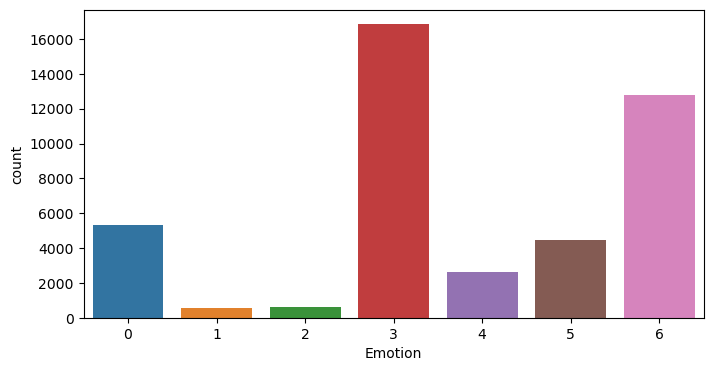

In [138]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=train_data)

<Axes: xlabel='Emotion', ylabel='count'>

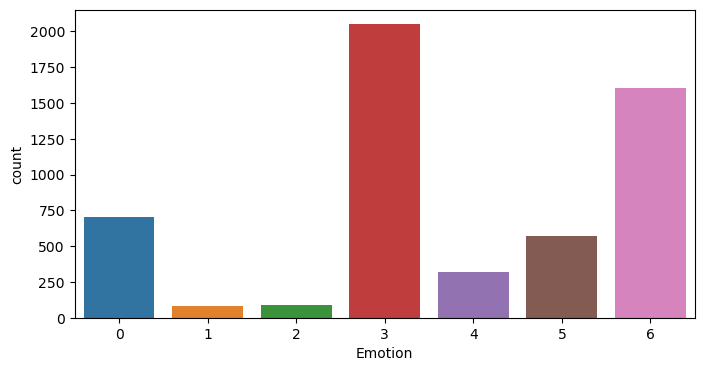

In [139]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=test_data)

<Axes: xlabel='Emotion', ylabel='count'>

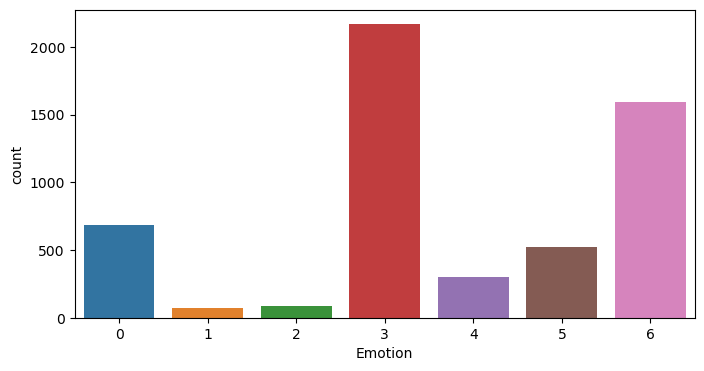

In [140]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=dev_data)

## Modelling